In [1]:
import numpy as np
import networkx as nx
import scipy.sparse.linalg as sla
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load Facebook Dataset
def load_facebook():
    """Loads the Facebook social network dataset and returns adjacency matrix, synthetic true labels, and the graph."""
    edges = pd.read_csv("/content/drive/MyDrive/Spectral analysis/facebook_combined.txt", sep=" ", header=None)

    # Build the graph
    G = nx.Graph()
    G.add_edges_from(edges.values)

    # Convert to adjacency matrix
    adj_matrix = nx.to_numpy_array(G)

    # Generate synthetic true labels using community detection
    communities = list(nx.community.greedy_modularity_communities(G))
    true_labels = np.zeros(len(G), dtype=int)
    for i, comm in enumerate(communities):
        for node in comm:
            true_labels[node] = i

    return adj_matrix, true_labels, G

# 2. Normal Clustering (KMeans on Adjacency Matrix)
def normal_clustering(adj_matrix, k):
    """Performs standard KMeans clustering on adjacency matrix."""
    X_norm = StandardScaler().fit_transform(adj_matrix)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_norm)
    return labels

# 3. Spectral Clustering (Original)
def spectral_clustering(adj_matrix, k):
    """Performs spectral clustering using Ng-Jordan-Weiss method."""
    D = np.diag(np.sum(adj_matrix, axis=1))
    L = D - adj_matrix
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L_sym = D_inv_sqrt @ L @ D_inv_sqrt

    eigvals, eigvecs = np.linalg.eigh(L_sym)
    X = eigvecs[:, :k]
    X_norm = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_norm)

    return labels

# 4. Enhanced Spectral Clustering
def normalized_laplacian(A):
    """Computes the normalized Laplacian."""
    D = np.diag(np.sum(A, axis=1))
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    return np.eye(len(D)) - D_inv_sqrt @ A @ D_inv_sqrt

def lanczos_eigen(L, k):
    """Computes k smallest eigenvectors using Lanczos algorithm."""
    L_sparse = csr_matrix(L)
    eigvals, eigvecs = sla.eigsh(L_sparse, k=k, which='SM')
    return eigvecs

def spectral_clustering_enhanced(A, k):
    """Enhanced Spectral Clustering with Lanczos, normalized Laplacian, and ML refinement."""
    L_norm = normalized_laplacian(A)
    X = lanczos_eigen(L_norm, k)
    X_norm = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_norm)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_norm, labels)
    refined_labels = rf.predict(X_norm)

    return refined_labels

# 5. Compute Modularity Index
def compute_modularity(adj_matrix, labels):
    """Computes the modularity index for a given clustering."""
    G = nx.from_numpy_array(adj_matrix)
    return nx.community.modularity(G, [np.where(labels == i)[0] for i in np.unique(labels)])

# 6. Compute Conductance
def compute_conductance(adj_matrix, labels):
    """Computes the average conductance for a given clustering."""
    G = nx.from_numpy_array(adj_matrix)
    conductance_values = []
    for cluster in np.unique(labels):
        nodes = np.where(labels == cluster)[0]
        if len(nodes) == 0 or len(nodes) == len(labels):
            continue
        conductance_values.append(nx.algorithms.cuts.conductance(G, nodes))
    return np.mean(conductance_values)

# 7. Load Dataset
adj_matrix, true_labels, G = load_facebook()
k = len(np.unique(true_labels))

# 8. Apply Clustering Methods
labels_normal = normal_clustering(adj_matrix, k)
labels_original = spectral_clustering(adj_matrix, k)
labels_enhanced = spectral_clustering_enhanced(adj_matrix, k)

# 9. Correct label mismatches
def match_labels(true_labels, pred_labels):
    """Matches predicted labels to true labels using the Hungarian algorithm."""
    confusion = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-confusion)
    label_mapping = {pred: true for pred, true in zip(col_ind, row_ind)}
    matched_labels = np.array([label_mapping.get(pred, pred) for pred in pred_labels])
    return matched_labels

labels_normal = match_labels(true_labels, labels_normal)
labels_original = match_labels(true_labels, labels_original)
labels_enhanced = match_labels(true_labels, labels_enhanced)

# 10. Evaluate Clustering Performance
metrics = {
    "Silhouette Score": [silhouette_score(adj_matrix, labels_normal),
                         silhouette_score(adj_matrix, labels_original),
                         silhouette_score(adj_matrix, labels_enhanced)],

    "Davies-Bouldin Score": [davies_bouldin_score(adj_matrix, labels_normal),
                             davies_bouldin_score(adj_matrix, labels_original),
                             davies_bouldin_score(adj_matrix, labels_enhanced)],

    "Calinski-Harabasz Index": [calinski_harabasz_score(adj_matrix, labels_normal),
                                calinski_harabasz_score(adj_matrix, labels_original),
                                calinski_harabasz_score(adj_matrix, labels_enhanced)],

    "Adjusted Rand Index": [adjusted_rand_score(true_labels, labels_normal),
                            adjusted_rand_score(true_labels, labels_original),
                            adjusted_rand_score(true_labels, labels_enhanced)],

    "Normalized Mutual Information": [normalized_mutual_info_score(true_labels, labels_normal),
                                      normalized_mutual_info_score(true_labels, labels_original),
                                      normalized_mutual_info_score(true_labels, labels_enhanced)],

    "Modularity Index": [compute_modularity(adj_matrix, labels_normal),
                         compute_modularity(adj_matrix, labels_original),
                         compute_modularity(adj_matrix, labels_enhanced)],

    "Conductance": [compute_conductance(adj_matrix, labels_normal),
                    compute_conductance(adj_matrix, labels_original),
                    compute_conductance(adj_matrix, labels_enhanced)]
}





Comparison of Clustering Methods:



,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Index,Adjusted Rand Index,Normalized Mutual Information,Modularity Index,Conductance
Normal KMeans,-0.107648,1.680893,156.318956,-0.004966,0.123312,0.578538,0.424000
Spectral,-0.098681,2.744613,156.071074,0.129027,0.312703,0.783012,0.073888
Enhanced Spectral,-0.098681,2.744613,156.071074,0.129027,0.312703,0.783012,0.073888


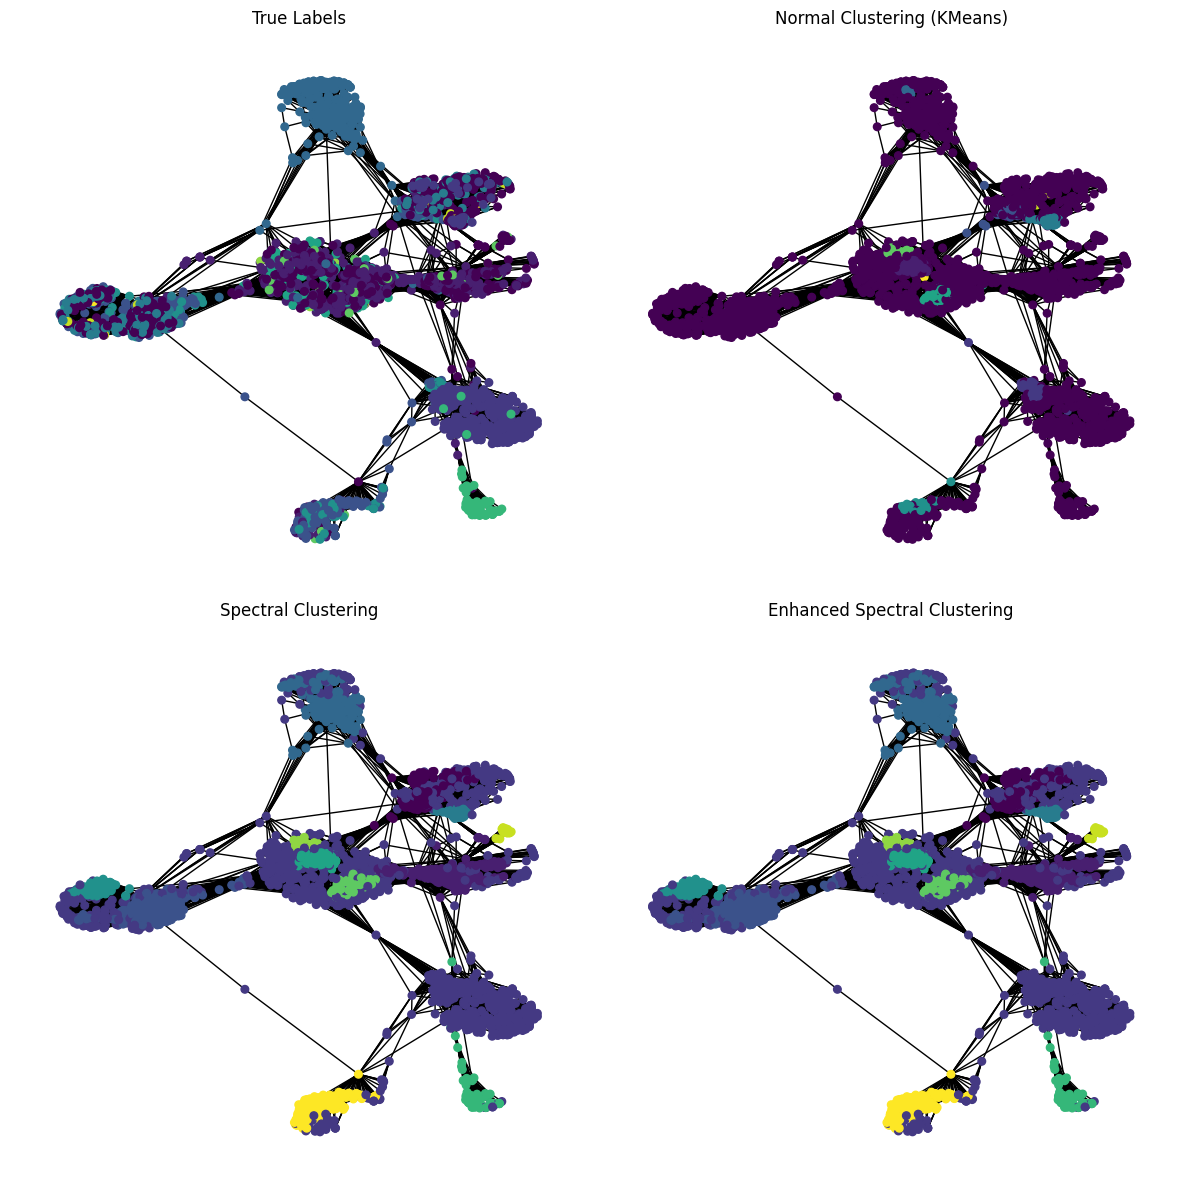

from matplotlib import pyplot as plt
df_metrics['Silhouette Score'].plot(kind='hist', bins=20, title='Silhouette Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Davies-Bouldin Score'].plot(kind='hist', bins=20, title='Davies-Bouldin Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Calinski-Harabasz Index'].plot(kind='hist', bins=20, title='Calinski-Harabasz Index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Adjusted Rand Index'].plot(kind='hist', bins=20, title='Adjusted Rand Index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Silhouette Score', y='Davies-Bouldin Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Davies-Bouldin Score', y='Calinski-Harabasz Index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Calinski-Harabasz Index', y='Adjusted Rand Index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Adjusted Rand Index', y='Normalized Mutual Information', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Silhouette Score']
  ys = series['Calinski-Harabasz Index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_metrics.sort_values('Silhouette Score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Silhouette Score')
_ = plt.ylabel('Calinski-Harabasz Index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Silhouette Score']
  ys = series['Conductance']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_metrics.sort_values('Silhouette Score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Silhouette Score')
_ = plt.ylabel('Conductance')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Silhouette Score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Silhouette Score'}, axis=1)
              .sort_values('Silhouette Score', ascending=True))
  xs = counted['Silhouette Score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_metrics.sort_values('Silhouette Score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Silhouette Score')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Davies-Bouldin Score']
  ys = series['Calinski-Harabasz Index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_metrics.sort_values('Davies-Bouldin Score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Davies-Bouldin Score')
_ = plt.ylabel('Calinski-Harabasz Index')

from matplotlib import pyplot as plt
df_metrics['Silhouette Score'].plot(kind='line', figsize=(8, 4), title='Silhouette Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Davies-Bouldin Score'].plot(kind='line', figsize=(8, 4), title='Davies-Bouldin Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Calinski-Harabasz Index'].plot(kind='line', figsize=(8, 4), title='Calinski-Harabasz Index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Adjusted Rand Index'].plot(kind='line', figsize=(8, 4), title='Adjusted Rand Index')
plt.gca().spines[['top', 'right']].set_visible(False)

In [3]:
# 11. Print Metrics in Table Format
print("\nComparison of Clustering Methods:\n")
df_metrics = pd.DataFrame(metrics, index=["Normal KMeans", "Spectral", "Enhanced Spectral"])
display(df_metrics)

# 12. Visualize Clusters
def plot_graph(G, labels, title, ax):
    """Visualizes the graph with cluster labels."""
    pos = nx.spring_layout(G, seed=42)
    ax.set_title(title)
    nx.draw(G, pos, node_color=labels, cmap="viridis", with_labels=False, node_size=30, ax=ax)

# 12. Visualize Clusters in 2x2 Grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

plot_graph(G, true_labels, "True Labels", axes[0, 0])
plot_graph(G, labels_normal, "Normal Clustering (KMeans)", axes[0, 1])
plot_graph(G, labels_original, "Spectral Clustering", axes[1, 0])
plot_graph(G, labels_enhanced, "Enhanced Spectral Clustering", axes[1, 1])

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()